# HK Models Comparison

## Motivation
We would like to learn how good can HK be simulated by HK with random sampling and HK with a social graph regarding the number of clusters and the convergence time.

## Experiment Design
We run all 3 models on confidence intervals ranging from 0.01 to 0.4 for 40 distinct initial opinion vectors. For the local knowledge models we select the average number of neighbors K to be in the interval [2, N * 0.2]. We used G(N, p) networks for the model with the social graph, but the results are almost identical when using preferential attachment graphs.

## Results
#### Convergence Time
The convergence time of the original model of Hegselmann and Krause is almost constant at about 8 rounds, with a small spike for confidence intervals around 0.25 where the two large clusters merge into one. On the other hand, the random sampling model requires a greater number of rounds to converge, with the same spike appearing around 0.25. Finally, the behaviour of the model which uses a graph is reversely proportional to the value of the confidence interval and it has a comparatively large variance. For all values of the confidence interval, the graph models takes more time to converge than the other two.
#### Clusters Number
The final number of clusters that are generated by the original HK model is really close to that generated by the random sampling. The slight divergence can be attributed to the inherently unstable nature of the HK model, as it was shown but the previous experiments. The graph model always leads to the creation of more clusters, compared to the two previous models.

In [1]:
%matplotlib inline
from __future__ import division, print_function

import numpy as np
from numpy import diag
import numpy.random as rand
from numpy.linalg import norm, inv, eigvals

import sys
from IPython import display
from tqdm import tqdm
from ipyparallel import Client

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, repeat
import pandas as pd

import models
from util import *
from viz import *

sns.set_context('paper', font_scale=1.5)

/home/user/opinions-research/env/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def list_stats(my_list):
    return '{0} values (min: {1}, max: {2})'.format(len(my_list), min(my_list), max(my_list))

In [3]:
rand.seed(44124)
N = 625
max_rounds = 10e3

# Values of epsilon
EPS_POINTS = 21
eps_list = np.linspace(0.01, 0.45, EPS_POINTS)

# Generate random opinion vectors
SIM_NUM = 100
s_list = [rand.rand(N) for _ in xrange(SIM_NUM)]

# Generate dfferent values of K
K_MIN = np.ceil(np.log10(N))
K_MAX = np.ceil(N * 0.1)
k_list = np.arange(K_MIN, K_MAX, 3).astype(int)
# Generate p_list
p_list = k_list / N

print('[+] N: {0}'.format(N))
print('[+] eps: {0}'.format(list_stats(eps_list)))
print('[+] s: {0} random values'.format(SIM_NUM))
print('[+] p: {0}'.format(list_stats(p_list)))
print('[+] K: {0}'.format(list_stats(k_list)))

[+] N: 625
[+] eps: 21 values (min: 0.01, max: 0.45)
[+] s: 100 random values
[+] p: 20 values (min: 0.0048, max: 0.096)
[+] K: 20 values (min: 3, max: 60)


In [4]:
def run_models(s):
    import models
    from util import cluster_count, cluster_count_net
    from numpy.linalg import norm
    import numpy as np
    
    result = tuple()
    N = len(s)
    # Original HK
    op_hk = models.hk(s, op_eps, max_rounds)
    time_hk = op_hk.shape[0]
    clusters_hk = cluster_count(op_hk[-1, :], op_eps)
    # HK Random Sampling
    op_rand = models.hk_rand(s, K, op_eps, max_rounds)
    time_rand = op_rand.shape[0]
    clusters_rand = cluster_count(op_rand[-1, :], op_eps)
    # HK with a network
    time_local, z_local = models.hk_local_nomem(A, s, op_eps, max_rounds)
    clusters_local = cluster_count_net(A, z_local, op_eps)
    # Calculate differences in number of clusters
    cdiff_1 = abs(clusters_hk-clusters_rand)
    cdiff_2 = abs(clusters_hk-clusters_local)
    # Calculate differences in opinion values (2-norm)
    ndiff_1 = norm(op_hk[-1] - op_rand[-1])
    ndiff_2 = norm(op_hk[-1] - z_local)
    # Create result tuple
    result += (time_hk, clusters_hk)
    result += (time_rand, clusters_rand, cdiff_1, ndiff_1)
    result += (time_local, clusters_local, cdiff_2, ndiff_2)
    return result

def calculate_averages(tuple_list):
    tuple_elems = len(tuple_list[0])
    averages = np.zeros(tuple_elems)
    num_elem = len(tuple_list)
    for t in tuple_list:
        for i in xrange(tuple_elems):
            averages[i] += t[i] / num_elem
    averages = np.round(averages)
    return averages.astype(int)

In [5]:
v, dv = parallel_init('/home/user/opinions-research/', profile='ssh')

[*] 15 parallel engines available
[*] Finished setting working directories


In [6]:
# Run Models
data = np.empty((0, 7))
t = tqdm(total=len(k_list) * EPS_POINTS)
# res: model_id, eps, K, time, clusters, cluster_diff, norm_diff
dv.clear()
for i, p in enumerate(p_list):
    A = gnp(N, p, verbose=False)
    K = k_list[i]
    ar = dv.push(dict(max_rounds=max_rounds, A=A, K=K))
    ar.get()     
    for eps in eps_list:
        ar = dv.push(dict(op_eps=eps))
        ar.get()
        result = parallel_map(v, run_models, s_list, silent=True)
        avg_result = calculate_averages(result)
        res_hk = np.array([0, eps, 0, avg_result[0], avg_result[1], 0, 0])
        res_rand = np.array([1, eps, K])
        res_rand = np.hstack((res_rand, avg_result[2:6]))
        res_local = np.array([2, eps, K])
        res_local = np.hstack((res_local, avg_result[6:10]))
        data = np.vstack((data, res_hk, res_rand, res_local))
        t.update()
t.close()

In [7]:
# Create DataFrame
df = pd.DataFrame(data=data, columns=['model_id', 'eps', 'K', 'rounds', 'clusters', 'cluster_diff', 'norm_diff'])
# Convert column types
df['K'] = df['K'].astype(int)
df['model_id'] = df['model_id'].astype(int)
df['model'] = 'hk'
df.loc[df['model_id'] == 1, 'model'] = 'random'
df.loc[df['model_id'] == 2, 'model'] = 'graph'

In [8]:
# Create 'eps_range' column
df['eps'] = df['eps'].round(decimals=2)
NUM_CUTS = 6
eps_cut = pd.cut(df['eps'], NUM_CUTS, precision=2, right=False)
df['eps_range'] = eps_cut
#df['eps_range'] = df['eps_range'].astype('category', ordered='True')

In [9]:
df.to_csv('hk_comparisons3.csv')

In [4]:
# Read already saved DataFrame
df = pd.read_csv('hk_comparisons3.csv')
eps_list = np.round(eps_list, decimals=2)

# Comparison of Convergence Times

/home/user/opinions-research/env/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


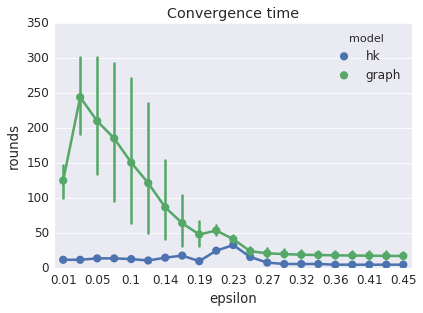

In [6]:
sns.pointplot(x='eps', y='rounds', data=df[df['model'] != 'random'], hue='model')
plt.xlabel('epsilon')
plt.ylabel('rounds')
plt.title('Convergence time')
plt.ylim(0, 350)
plt.xticks(np.arange(0, 21, 2), eps_list[0:21:2])
plt.show()

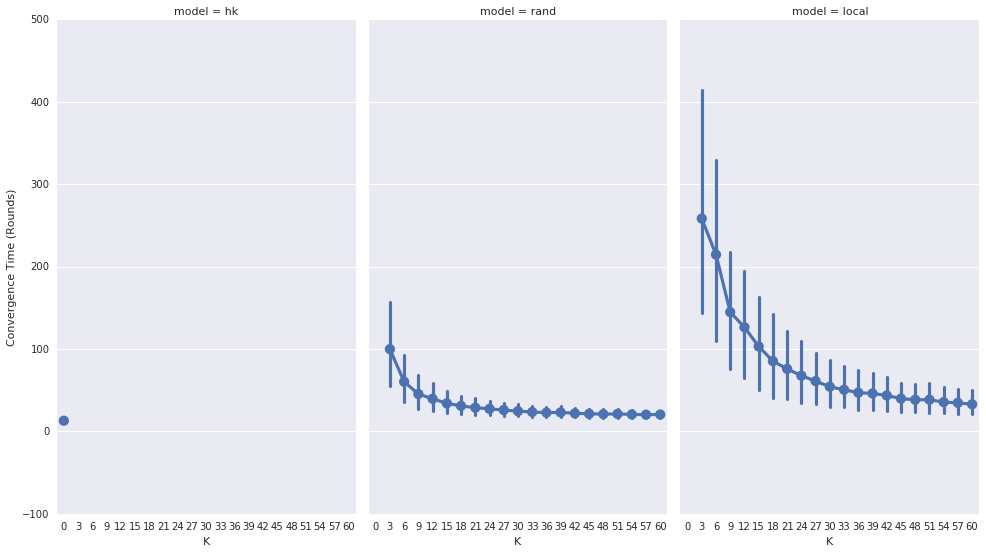

In [8]:
g = sns.factorplot(x='K', y='rounds', col='model', data=df)
g.set_ylabels('Convergence Time (Rounds)')
fig = plt.gcf()
fig.set_size_inches(14, 9)
plt.show()

# Number of clusters 
- Every Model
- Dependent on ε

For detailed ranges of eps see the labels above because there is not enough space here

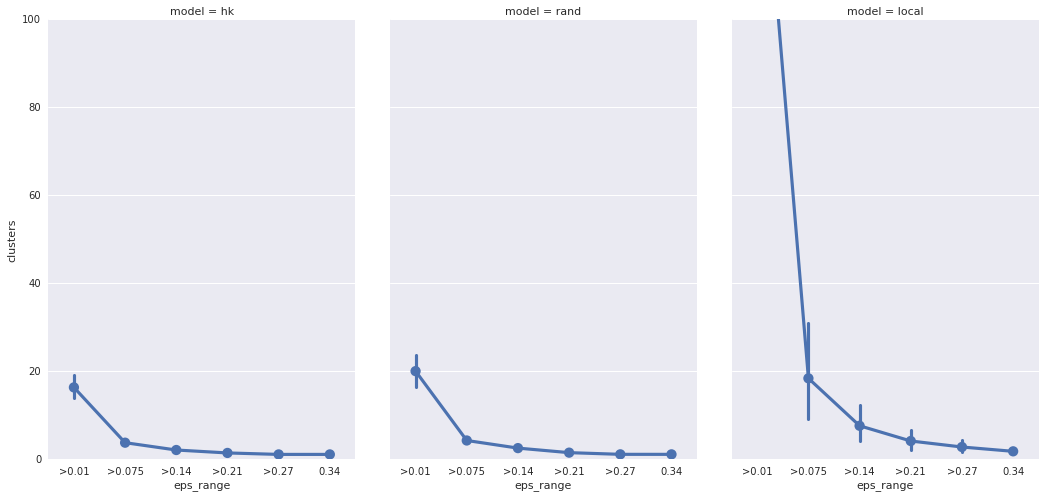

In [9]:
g = sns.factorplot(x='eps_range', y='clusters', col='model', data=df)
g.set(ylim=(0, 100))
g.set_xticklabels(['>0.01', '>0.075', '>0.14', '>0.21', '>0.27','0.34'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

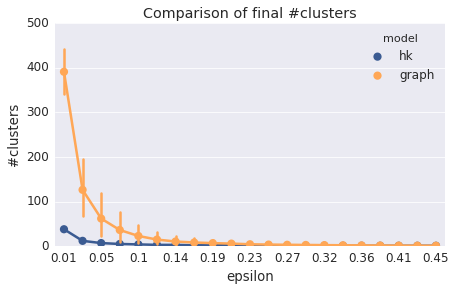

In [5]:
pal1 = sns.xkcd_palette(['denim blue', 'pale orange'])
g = sns.pointplot(x='eps', y='clusters',hue='model', data=df[df['model'] != 'random'], palette=pal1)
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.ylim(0, 500)
plt.xlabel('epsilon')
plt.ylabel('#clusters')
plt.title('Comparison of final #clusters')
plt.xticks(np.arange(0, 21, 2), eps_list[0:21:2])
plt.show()

# Number of clusters 

- By Model
- Dependent on K

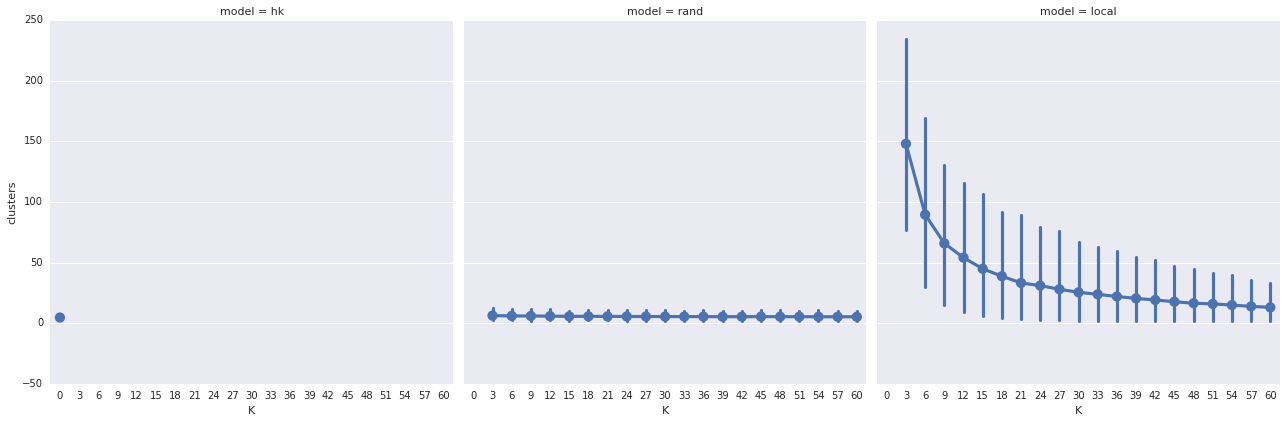

In [16]:
sns.factorplot(x='K', y='clusters', data=df, col='model', size=6)
plt.show()

# Number of clusters 

- Every Model
- Dependent on K
- Dependent on range of ε

#### Legend
- x-axis: K
- y-axis: number of clusters
- graphs column: type of model
- graphs row: eps_range

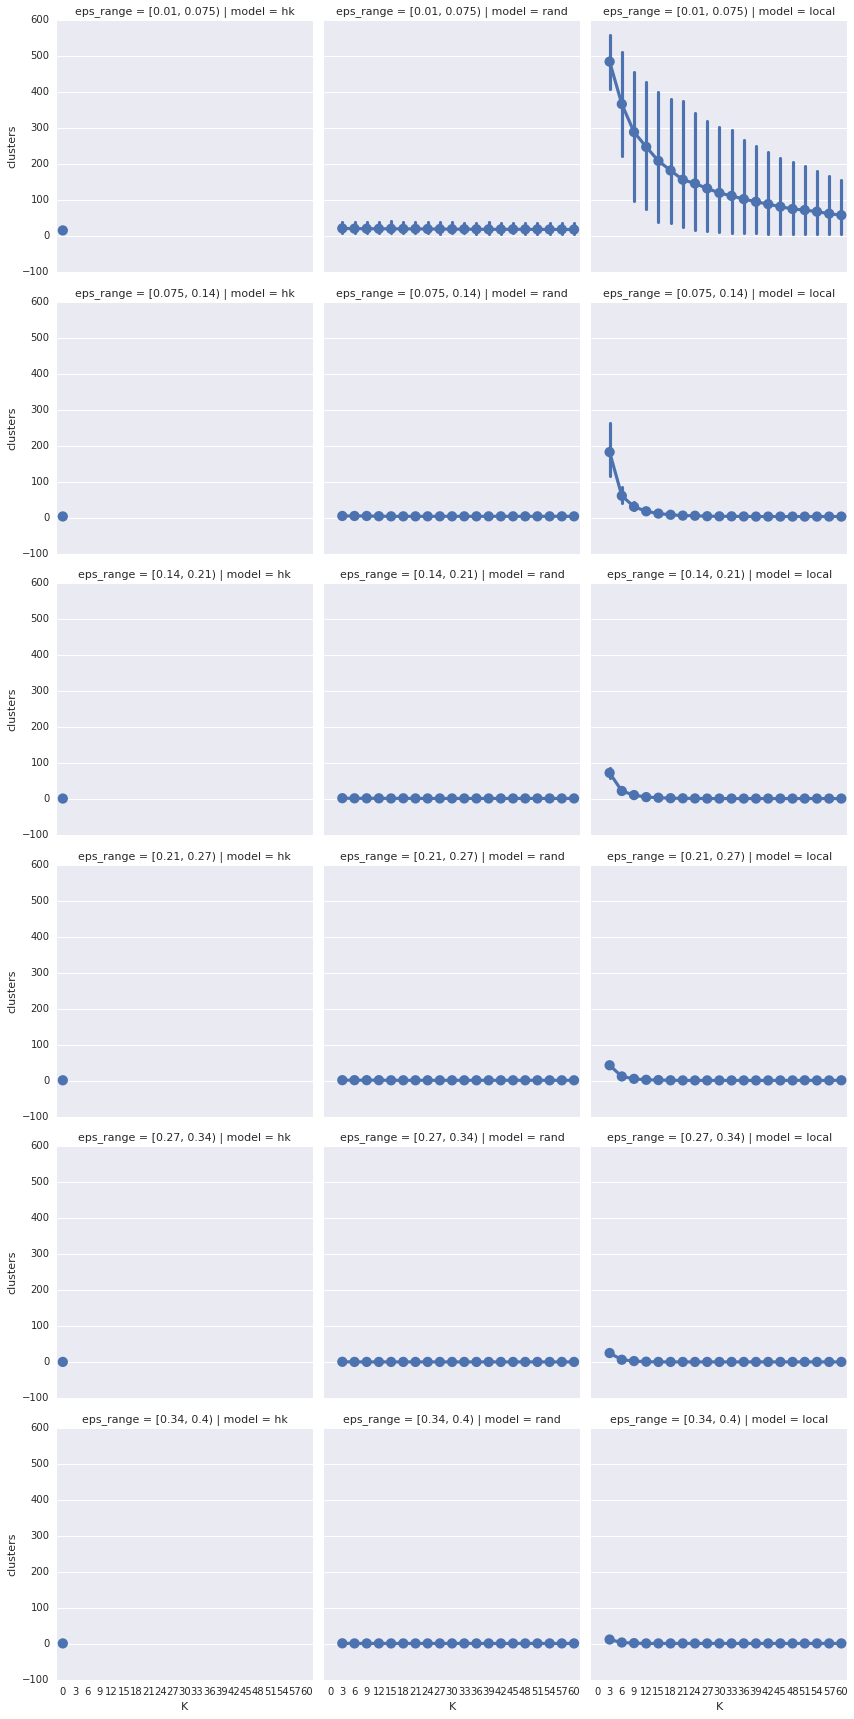

In [27]:
sns.factorplot(x='K', y='clusters', data=df, col='model', row='eps_range')
plt.show()

# Normalized $L_{2}$ distance of final opinions

- Distance of opinion vectors divided by the number of clusters

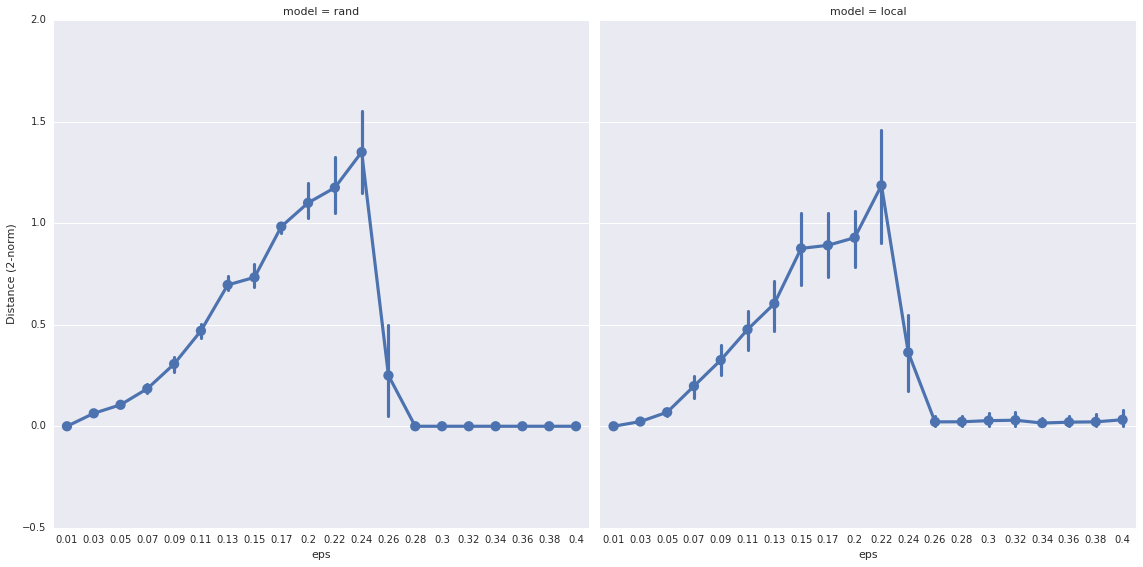

In [20]:
df['dist2'] = df['norm_diff'] / df['clusters']
g = sns.factorplot(x='eps', y='dist2', data=df[df['model'] != 'hk'], col='model', size=8)
g.set_ylabels('Distance (2-norm)')
plt.show()

# More detailed

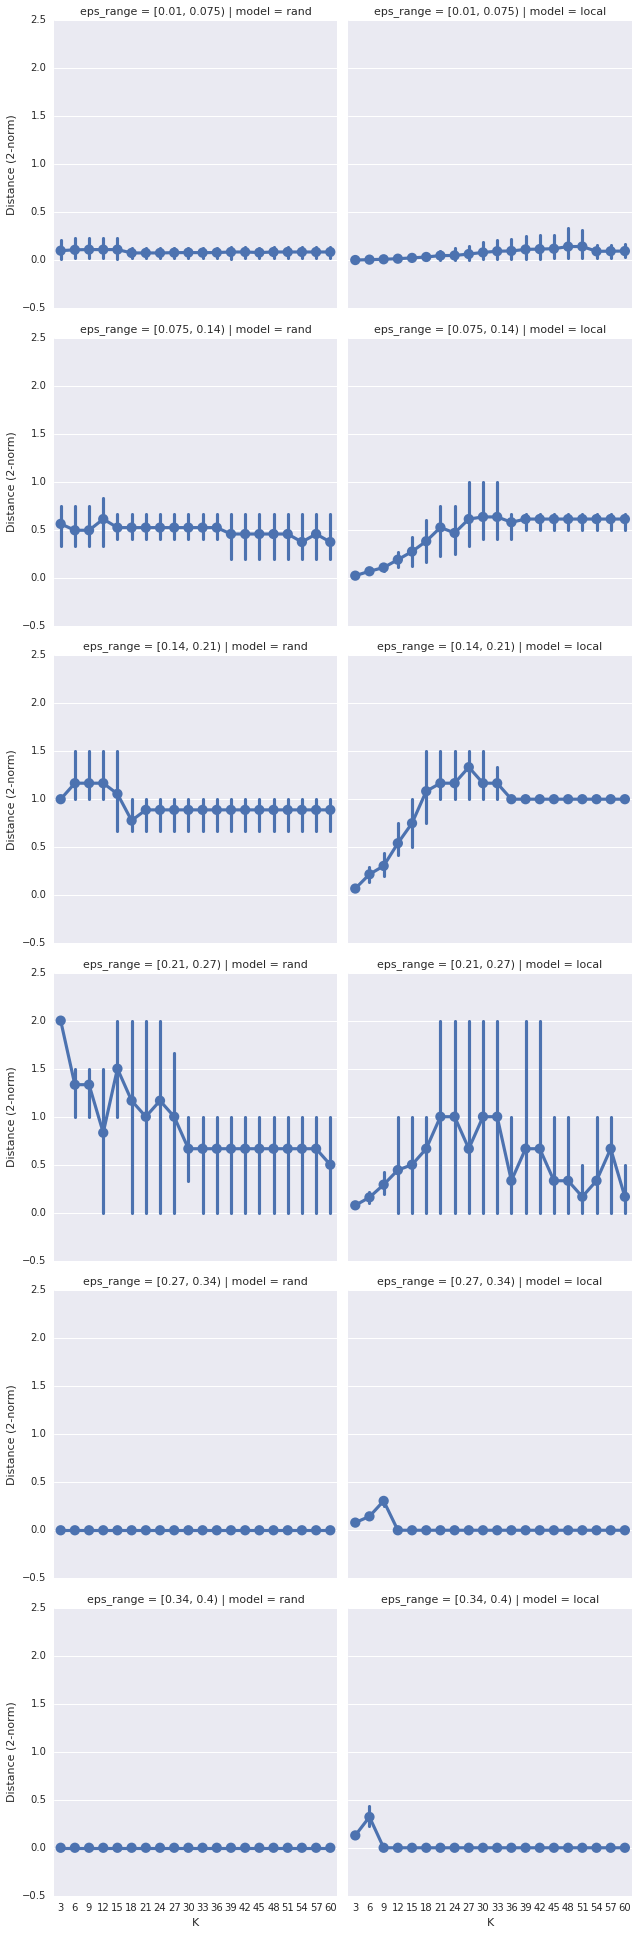

In [21]:
g = sns.factorplot(x='K', y='dist2', data=df[df['K'] > 0], col='model', row='eps_range', size=4.5)
g.set_ylabels('Distance (2-norm)')
plt.show()